# OPEN METEO API

In [2]:
#Install
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install python-dotenv

In [17]:
#Import Dependencies
import openmeteo_requests

import numpy as np
import requests_cache
import pandas as pd
from retry_requests import retry

In [4]:
#Setup the Open-Meteo API Client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [5]:
#Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [36.154, 40.7128, 34.0549],
	"longitude": [95.9928, 74.006, 118.2426],
	"start_date": "2014-01-01",
	"end_date": "2023-12-31",
	"hourly": "relative_humidity_2m",
	"daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"precipitation_unit": "inch",
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

In [6]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 36.16871643066406°N 96.07791900634766°E
Elevation 4246.0 m asl
Timezone b'America/Chicago' b'CDT'
Timezone difference to GMT+0 -18000 s


In [7]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 36.16871643066406°N 96.07791900634766°E
Elevation 4246.0 m asl
Timezone b'America/Chicago' b'CDT'
Timezone difference to GMT+0 -18000 s
                           date  relative_humidity_2m
0     2014-01-01 05:00:00+00:00             59.558182
1     2014-01-01 06:00:00+00:00             55.147812
2     2014-01-01 07:00:00+00:00             56.722488
3     2014-01-01 08:00:00+00:00             61.792240
4     2014-01-01 09:00:00+00:00             64.751877
...                         ...                   ...
87643 2024-01-01 00:00:00+00:00             41.523659
87644 2024-01-01 01:00:00+00:00             44.350803
87645 2024-01-01 02:00:00+00:00             39.358746
87646 2024-01-01 03:00:00+00:00             35.514065
87647 2024-01-01 04:00:00+00:00             37.143208

[87648 rows x 2 columns]


In [8]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

                          date  temperature_2m_max  temperature_2m_min  \
0    2014-01-01 05:00:00+00:00           19.540400           -6.199600   
1    2014-01-02 05:00:00+00:00            9.550400          -24.199596   
2    2014-01-03 05:00:00+00:00            6.940401          -24.559601   
3    2014-01-04 05:00:00+00:00           18.820400          -14.029602   
4    2014-01-05 05:00:00+00:00           14.050400          -12.409599   
...                        ...                 ...                 ...   
3647 2023-12-27 05:00:00+00:00           24.994400           17.704399   
3648 2023-12-28 05:00:00+00:00           19.594400            4.834400   
3649 2023-12-29 05:00:00+00:00           21.214401            9.064398   
3650 2023-12-30 05:00:00+00:00           23.554399           17.434399   
3651 2023-12-31 05:00:00+00:00           23.914400            1.774403   

      precipitation_sum  
0                   0.0  
1                   0.0  
2                   0.0  
3      

# EPA API CONCATED

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv('Resources/EPA.env')

api_key = os.getenv('EPA_API_KEY')
email_key = os.getenv('MY_EMAIL')


def fetch_aqi_data(year, api_key, cbsa):
    url = 'https://aqs.epa.gov/data/api/annualData/byCBSA'
    params = {
        'email': email_key,
        'key': api_key,
        'param': '88101',  # Parameter code for PM2.5
        'bdate': f'{year}0101',
        'edate': f'{year}1231',
        'cbsa': cbsa  # CBSA defined in cbsa_codes
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['Data'])

# Define the range of years / CBSA
years = range(2014, 2024)  # Adjust this range as needed
cbsa_codes = {
    'Tulsa': '46140',
    'Los Angeles': '31080',
    'New York': '35620'
}
# Fetch and concatenate data for each year
# all_data = pd.DataFrame()
# for year in years:
#     yearly_data = fetch_aqi_data(year, api_key)
#     all_data = pd.concat([all_data, yearly_data])
all_data = pd.DataFrame()

for cbsa_name, cbsa_code in cbsa_codes.items():
    for year in years:
        yearly_data = fetch_aqi_data(year, api_key, cbsa_code)
        if not yearly_data.empty:
            yearly_data['CBSA'] = cbsa_name
            yearly_data['year'] = year
            all_data = pd.concat([all_data, yearly_data], ignore_index=True)

# Reset the index after concatenation
all_data.reset_index(drop=True, inplace=True)



# # View the combined DataFrame
print(all_data.head())
print(all_data.tail())

  state_code county_code site_number parameter_code  poc   latitude  \
0         40         143        0174          88101    3  35.953708   
1         40         143        0174          88101    3  35.953708   
2         40         143        0174          88101    3  35.953708   
3         40         143        0174          88101    3  35.953708   
4         40         143        0174          88101    3  35.953708   

   longitude  datum                 parameter sample_duration_code  ...  \
0 -96.004975  WGS84  PM2.5 - Local Conditions                    1  ...   
1 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
2 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
3 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
4 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   

  tenth_percentile local_site_name         site_address     state  county  \
0              3.3     TULSA SOUTH  502 EAST 

# DATA CONCATED 

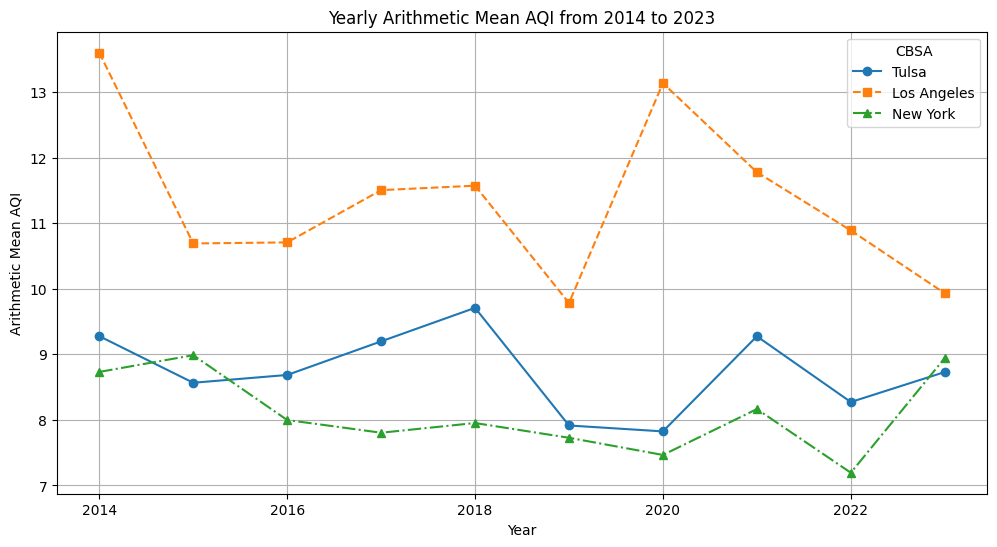

In [11]:
#Code to Combine Data (Under Construction)
# Yearly arithmetic mean for each CBSA
if not all_data.empty:
    # Convert 'arithmetic_mean' to numeric, coerce errors to NaN
    all_data['arithmetic_mean'] = pd.to_numeric(all_data['arithmetic_mean'], errors='coerce')

    yearly_aqi = all_data[all_data['arithmetic_mean'].notna()].groupby(['CBSA', 'year'])['arithmetic_mean'].mean().reset_index()

    # Plot 
    plt.figure(figsize=(12, 6))
    markers = ['o', 's', '^']  # Different markers - CBSA
    linestyles = ['-', '--', '-.']  # Different line - CBSA
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = yearly_aqi[yearly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            plt.plot(cbsa_data['year'], cbsa_data['arithmetic_mean'],
                     marker=markers[idx % len(markers)], linestyle=linestyles[idx % len(linestyles)], label=cbsa)

    plt.title('Yearly Arithmetic Mean AQI from 2014 to 2023')
    plt.xlabel('Year')
    plt.ylabel('Arithmetic Mean AQI')
    plt.legend(title='CBSA')
    plt.grid(True)
    plt.show()
else:
    print("No valid data to plot.")

In [12]:
# Reset index 'first_max_datetime' to datetime
all_data.reset_index(drop=True, inplace=True)
if 'first_max_datetime' in all_data.columns:
    all_data['first_max_datetime'] = pd.to_datetime(all_data['first_max_datetime'])

# Convert 'first_max_value' to numbers, coerce errors 
if 'first_max_value' in all_data.columns:
    all_data['first_max_value'] = pd.to_numeric(all_data['first_max_value'], errors='coerce')

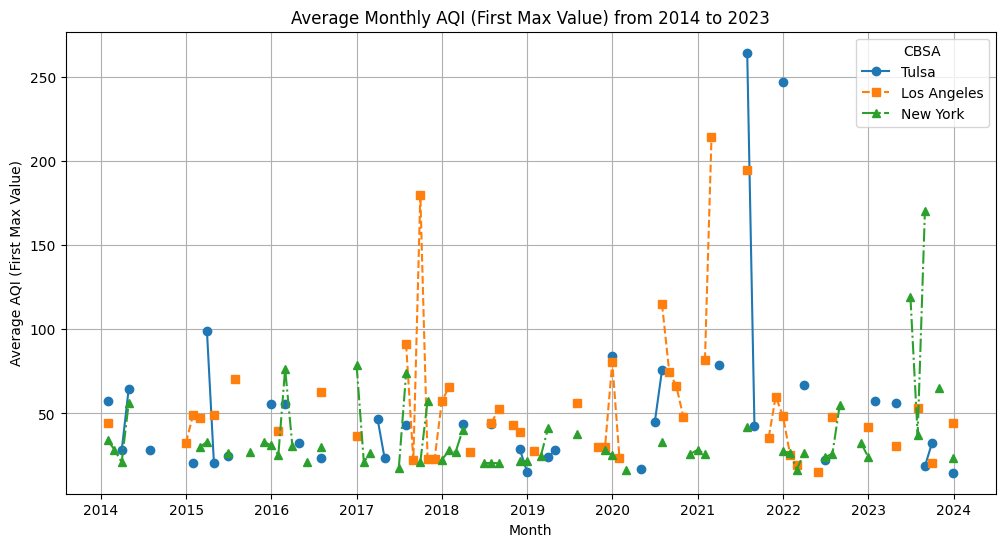

In [13]:
# Change to month and fill missing values
if not all_data.empty and 'first_max_datetime' in all_data.columns:
    all_data.set_index('first_max_datetime', inplace=True)
    monthly_aqi = all_data[all_data['first_max_value'].notna()].groupby('CBSA').resample('ME')['first_max_value'].mean()
    monthly_aqi = monthly_aqi.reset_index()

    # Plot 
    plt.figure(figsize=(12, 6))
    markers = ['o', 's', '^']  # Different markers - CBSA
    linestyles = ['-', '--', '-.']  # Different line - CBSA
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = monthly_aqi[monthly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            plt.plot(cbsa_data['first_max_datetime'], cbsa_data['first_max_value'],
                     marker=markers[idx % len(markers)], linestyle=linestyles[idx % len(linestyles)], label=cbsa)

    plt.title('Average Monthly AQI (First Max Value) from 2014 to 2023')
    plt.xlabel('Month')
    plt.ylabel('Average AQI (First Max Value)')
    plt.legend(title='CBSA')
    plt.grid(True)
    plt.show()
else:
    print("No valid data to plot.")

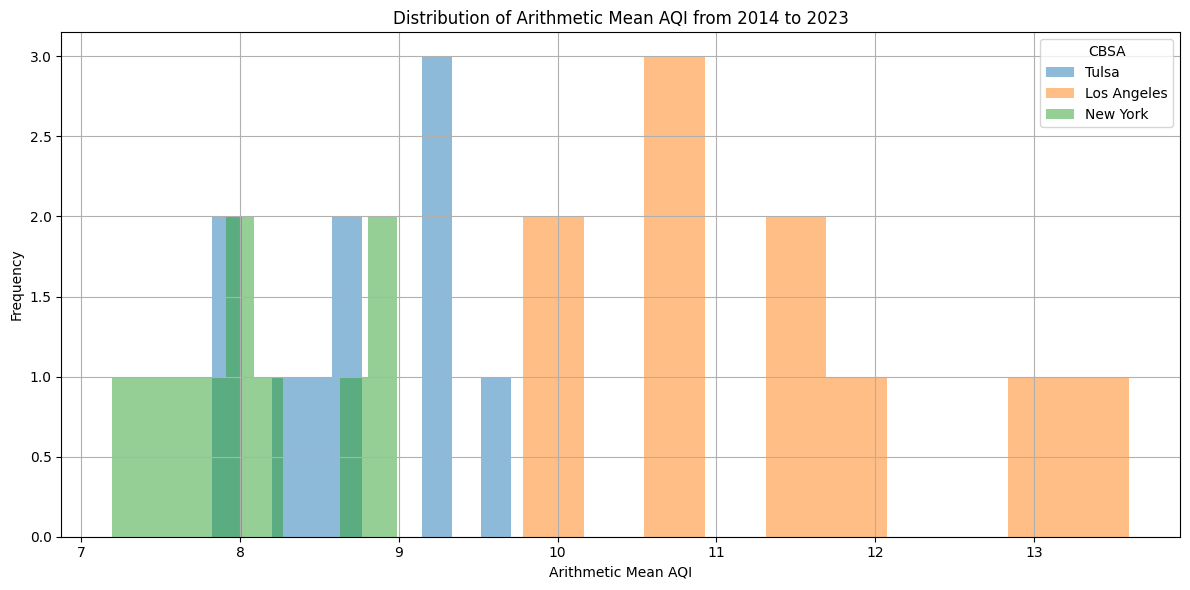

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

if not all_data.empty:
    # Convert 'arithmetic_mean' to numeric, coerce errors to NaN
    all_data['arithmetic_mean'] = pd.to_numeric(all_data['arithmetic_mean'], errors='coerce')

    yearly_aqi = all_data[all_data['arithmetic_mean'].notna()].groupby(['CBSA', 'year'])['arithmetic_mean'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    bins = 10  # Number of bins for the histogram
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = yearly_aqi[yearly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            plt.hist(cbsa_data['arithmetic_mean'], bins=bins, alpha=0.5, label=cbsa)

    plt.title('Distribution of Arithmetic Mean AQI from 2014 to 2023')
    plt.xlabel('Arithmetic Mean AQI')
    plt.ylabel('Frequency')
    plt.legend(title='CBSA')
    plt.grid(True)
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()
else:
    print("No valid data to plot.")

#This code will create a histogram showing the distribution of the arithmetic mean AQI for each CBSA.
#The plt.hist() function is used to create the histogram, with the number of bins specified by the bins variable. 
#The alpha parameter is set to 0.5 to make the bars slightly transparent.
#The rest of the code remains the same as before, including the title, labels, legend, grid, and spacing adjustment.

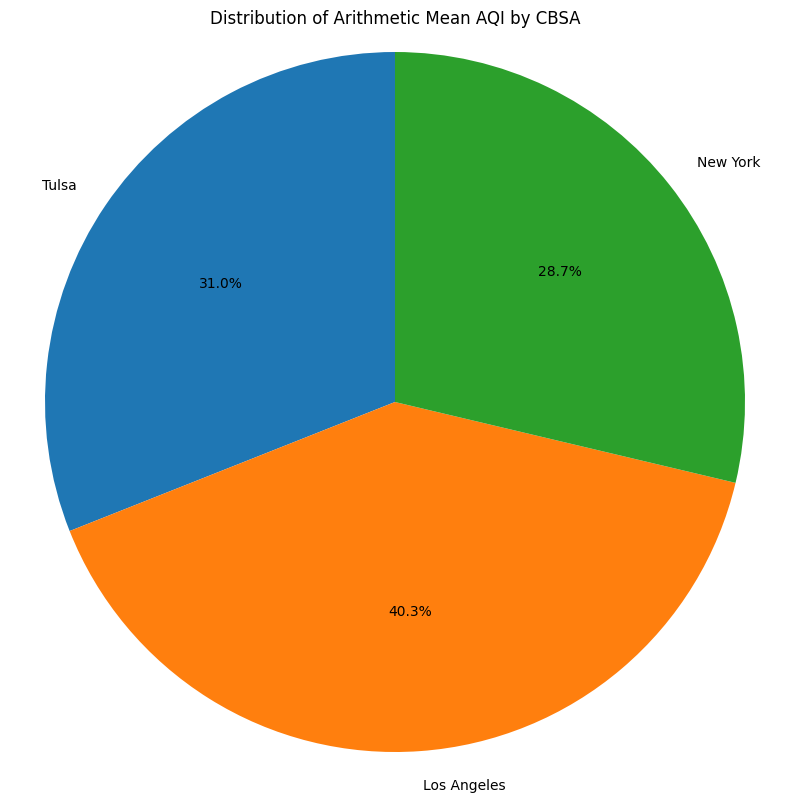

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

if not all_data.empty:
    # Convert 'arithmetic_mean' to numeric, coerce errors to NaN
    all_data['arithmetic_mean'] = pd.to_numeric(all_data['arithmetic_mean'], errors='coerce')

    yearly_aqi = all_data[all_data['arithmetic_mean'].notna()].groupby(['CBSA', 'year'])['arithmetic_mean'].mean().reset_index()

    plt.figure(figsize=(8, 8))
    labels = []
    sizes = []
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = yearly_aqi[yearly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            labels.append(cbsa)
            sizes.append(cbsa_data['arithmetic_mean'].sum())

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Arithmetic Mean AQI by CBSA')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("No valid data to plot.")

#This code will create a pie chart showing the distribution of the arithmetic mean AQI for each CBSA.
#The plt.pie() function is used to create the pie chart, with the sizes of the slices determined by the sum of the arithmetic mean AQI values for each CBSA.
#The labels parameter is used to provide labels for each slice, and the autopct parameter is used to display the percentage values on the chart. 
#The startangle parameter is set to 90 to rotate the chart.
#The rest of the code remains the same as before, including the title, axis adjustment, and spacing adjustment.